In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from tqdm import tqdm
from censai.data.lenses_tng_v2 import decode_all, decode_train, decode_physical_model_info
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.definitions import log_10

In [2]:
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_noshift40k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses128_hTNG100_10k_verydiffuse"
datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_200k_control_validated_train/"
# datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_2M/"


# files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = [os.path.join(datapath, "data_10.tfrecords")]
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
print(physical_params)
dataset = dataset.map(decode_all)


{'image fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'kappa fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'source fov': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'src pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'kappa pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'noise rms': <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, 'psf sigma': <tf.Tensor: shape=(), dtype=float32, numpy=0.06>}


In [4]:

kappas = []
galaxies = []
lenses = []
i = 0
for example in tqdm(dataset):
    kappas.append(example['kappa'])
    galaxies.append(example['source'])
    lenses.append(example['lens'])
    i += 1
    if i == 200:
        break


199it [00:00, 910.05it/s]


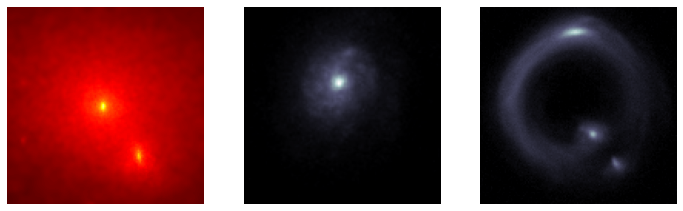

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
i = 23
axs[0].imshow(kappas[i][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[1].imshow(galaxies[i][..., 0], cmap="bone", vmin=0, vmax=1)
axs[2].imshow(lenses[i][..., 0], cmap= "bone", vmin=0, vmax=1)
for i in range(3):
    axs[i].axis("off")

In [31]:
kappa = kappas[i]
galaxy = galaxies[i]
lens = lenses[i]